Linear Regression
=========

# Problem 2

* [Problem Description](#problem_description)
* [Solution 1: Applying Gradient Descent (Keras)](#gradient_descent_keras)
* [Solution 2: Applying Gradient Descent (Tensorflow)](#gradient_descent_tensorflow)
* [Solution 3: Analytical solution with Least Squares Error minimization](#least-squares-error-minimization)
* [Comparing all 3 solutions](#comparing_solutions)

In this problem we will find the best line that fits a given model. For theory details, please see [Linear Regression Theory](Linear_Regression_Theory.ipynb).

<a id='problem_description'></a>
### Problem Description

In this problem we will be using a function to create a cloud of points and based on these generated points we will try to find the best line to fit the data.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

'''This function creates a cloud of points in a line specified between two points: initialPoint and finalPoint
Input parameters: 
    initialPoint  : initial point of the line that represents the cloud
    finalPoint    : final point of the line that represents the cloud
    scatter       : range in y-axis indicating how spread the cloud of points is
    multiplicity  : number of points in the cloud for every x point '''
def PointsCloud(initialPoint, finalPoint, scatter, multiplicity):
    # Angular coefficient
    ang_coef = (initialPoint[1]-finalPoint[1])/(initialPoint[0]-finalPoint[0]) 
    # Linear coefficient
    lin_coef = -ang_coef*initialPoint[0]+initialPoint[1]
    i = [val for val in np.arange(initialPoint[0], finalPoint[0], 1) for _ in np.arange(0, multiplicity)]
    y = [(ang_coef*ii)+lin_coef for ii in i]
    random.seed(26051984) # to enable reproducibility
    r = [random.uniform(0, 1)*scatter+(yy-(0.5*scatter)) for yy in y]
    points = [[i[idx], r[idx]] for idx in range(len(i))]
    return points

Let's define and visualize our cloud of points using the function above.<p>
This function takes a line as input, which will be the base of the generated points. Our line is represented by the connection between the points (10,12) and (50,53). For each point in x-axis it will have 4 points (multiplicity) and 30 will be our scatter value, representing the range in y-axis indicating how vertically spaced the cloud is.

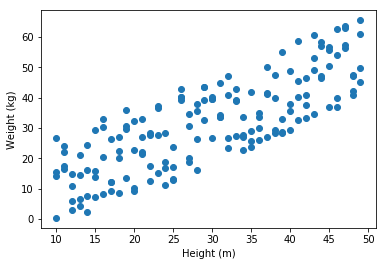

In [2]:
# Defining initial and final points
initialPoint = (10, 12)
finalPoint = (50,53)
points = PointsCloud(initialPoint, finalPoint, 30, 4)
# Defining x and y
x = np.array([i[0] for i in points], dtype=np.float)
y = np.array([i[1] for i in points], dtype=np.float)
# Plotting points
plt.scatter(x, y)
plt.xlabel('Height (m)')
plt.ylabel('Weight (kg)')
plt.show()

The goal of this Problem is to **find the best line that fits the points above**. For that, we will use different approaches and compare the results.

<a id='gradient_descent_keras'> </a>
### Solution 1: Applying Gradient Descent (Keras)

We could see linear regression as a 1-layer neural network with a **linear activation function ($\sigma$)**.
<img src='figures/lr_with_activation.png'>

In this solution we will be using [Tensorflow](https://www.tensorflow.org) with [Keras](https://keras.io/).

So, let's create our single-neuron model: 

In [3]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
# Cleaning sessions previously started
keras.backend.clear_session()
# Creating our model
model = Sequential()
model.add(Dense(units=1, input_dim=1, activation='linear', kernel_initializer='zero'))
# Using Gradient Descent as optimizer
# Obs: When the batch size is equal to the amount of samples, Stochastic Gradient Descent becomes Batch Gradient Descent
sgd = SGD(lr=0.2)
# Adding the Mean Squared Error loss function and Gradient Descent optimizer to our model
model.compile(optimizer=sgd, loss='mean_squared_error')

Using TensorFlow backend.


Once our model is created, let's train using the model.fit() function:

In [4]:
# As we have only one sample and the gradient is updated after every batch passing through the neuron, 
# let's make our batch longer to avoid having the weights (betas) updated very often.
batch_size = 50
epochs = 1000
# Train our model silently (verbose=0)
result = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=0)

Plotting our loss to see how it dropped throughout the training:

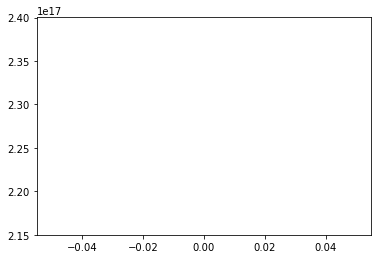

In [5]:
plt.plot(result.history["loss"])
plt.show()

**What? Something went very wrong here!** Our results show no error. Let's visualize the first 5 losses:

In [6]:
result.history["loss"][0:5]

[2.2750866550544314e+17, inf, inf, inf, nan]

As seen above, keras only recorded the first epoch error. The other values are either 'Inf' (infinite) or 'Nan' (not a number), meaning an overflow occurred.<br>
We did not normalize our data and sometimes the gradient explodes when we don't normalize our data. Notice that the error in our first epoch was very high (e+17) and then it went to infinite.<br>
In order to overcome this problem let's normalize our data. Below we will repeat the whole process with our normalized data.

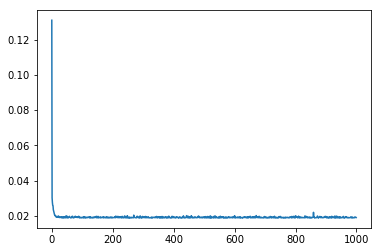

In [7]:
# Normalizing the data
x_norm = x
y_norm = y
x_norm -= x_norm.min()
x_norm /= x_norm.max()   
y_norm -= y_norm.min()
y_norm /= y_norm.max()
# Cleaning sessions previously started
keras.backend.clear_session()
# Creating our model
model = Sequential()
model.add(Dense(units=1, input_dim=1, activation='linear', kernel_initializer='zero'))
# Using Gradient Descent as optimizer
sgd = SGD(lr=0.2)
# Adding the Mean Squared Error loss function and Gradient Descent optimizer to our model
model.compile(optimizer=sgd, loss='mean_squared_error')
# Train
batch_size = 50
epochs = 1000
# Train with our normalized data
result = model.fit(x_norm, y_norm, batch_size=batch_size, epochs=epochs, verbose=0)
# Plot our MSE
plt.plot(result.history["loss"])
plt.show()

Now we have our model trained, we'll measure our erros, see the parameters we found (beta_0 and beta_1) and plot the line.

beta_0: 0.163225
beta_1: 0.606449 
Least Squares Eror: 3.02362877583
Mean Squared Eror: 0.0188976809382


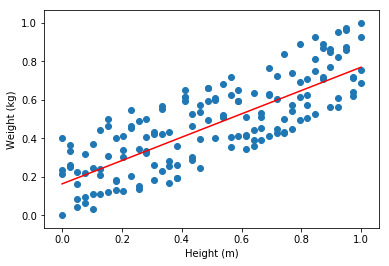

In [8]:
# Get beta_0 and beta_1
[beta_1, beta_0] = model.get_weights()
beta_1 = beta_1[0] #Keras returns our beta_1 as a vector
print("beta_0: %s" % beta_0[0])
print("beta_1: %s " % beta_1[0])
# Measure errors
mse = model.evaluate(x_norm, y_norm, verbose = 0)
# mse = np.mean(np.square(y - (beta_0 + np.multiply(beta_1,x)))) could also be calculated directly with our equation
lse = np.sum(np.square(y_norm - (beta_0 + np.multiply(beta_1,x_norm))))
print('Least Squares Eror: %s' % lse)
print('Mean Squared Eror: %s' % mse)
# Plotting
y_min = beta_0 + (beta_1*np.min(x_norm))
y_max = beta_0 + (beta_1*np.max(x_norm))
plt.scatter(x_norm, y_norm)
plt.xlabel('Height (m)')
plt.ylabel('Weight (kg)')
plt.plot([np.min(x_norm),np.max(x_norm)], [y_min,y_max],c='r')
plt.show()

I encourage you to train with different epochs. Notice the more we train, the less our errors get.<p>
If you train with 10000 epochs, you will obtain the following results: <br>
beta_0: 0.16777468<br>
beta_1: 0.61720169<br>
Least Squares Eror: 2.99910858853<br>
Mean Squared Eror: 0.0187444284558

<a id='gradient_descent_tensorflow'> </a>
### Solution 2: Applying Gradient Descent (Tensorflow)

Let's find our solution directly with Tensorflow. First let's import the packages we will use:

In [9]:
import tensorflow as tf
# This is a .py file to with useful functions
from utils import show_graph
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import numpy.random as rand
# To enable reproducibility
rand.seed(26051984)

Defining our graph:

In [10]:
tf.reset_default_graph()
# Defining variables to be updated during training
betas = tf.Variable(np.zeros((2,1), np.float64)) # initializing beta_0 as 0 and beta_1 as 0
Xb = np.hstack([np.ones(shape=(len(x_norm),1)), np.reshape(x_norm, (len(x_norm),1))])
Yb = np.reshape(y_norm,(len(y_norm),1))
# Input is constant (it will never be changed)
x_const = tf.constant(Xb)
# Output is also a constant
y_const = tf.constant(Yb)
# Defining our output
output = tf.matmul(x_const,betas)
error = output-y_const
mse = tf.reduce_mean(tf.square(error))
lse = tf.reduce_sum(tf.square(error))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(mse)

Now let's run our graph and plot our results:

In [11]:
num_epochs = 1000
learning_rate = 0.2

# Creating our session
with tf.Session() as session:
    # Initializing our variables
    session.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        # Run our graph
        out = session.run(optimizer)
        best_betas = betas.eval()
        # Calculate error every 1000 epochs
        if epoch % 1000 == 0:
            print("Epoch %s MSE = %s LSE = %s" %(epoch, mse.eval(), lse.eval()))

# Getting beta 0 and beta 1
beta_0 = best_betas[0][0]
beta_1 = best_betas[1][0]
# Printing results
print("beta_0: %s" % beta_0)
print("beta_1: %s " % beta_1)

Epoch 0 MSE = 0.170857409193 LSE = 27.3371854708
beta_0: 0.173145229628
beta_1: 0.611950453073 


If we make our training with 10000 epochs, we will notice our errors will drop significantly. With 10000 epochs, these are the results we will get:<br>
Epoch 9000 MSE = 0.0187344786198 LSE = 2.99751657917<br>
beta_0: 0.173145032501<br>
beta_1: 0.6119508201

<a id='least-squares-error-minimization'></a>
### Solution 3: Least Squares Error minimization

Now it is time to compare our results above with our analytic solution. You can check the theory at [Linear Regression Theory](Linear_Regression_Theory.ipynb).<br>
The line that best fits our model is given by:

$$\begin{align*} 
\boxed{y = \beta_0 + \beta_1 x \text{ , where }
            \left\{
                \begin{array}{ll}
                  \beta_0 = \bar{y} - \beta_1\bar{x}\\
                  \beta_1 = \frac{\sum_{i=1}^N \left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)}{\sum_{i=1}^N \left(x_i - \bar{x}\right)^2}
                \end{array}\right.}
\end{align*} $$

Using NumPy, let's find $\beta_0$ and $\beta_1$.

In [12]:
# Finding y and x means
y_mean = np.mean(y_norm)
x_mean = np.mean(x_norm)
# Finding beta_1 and beta_0
beta_1 = np.sum((x_norm-x_mean)*(y_norm-y_mean))/np.sum(np.square(x_norm-x_mean))
beta_0 = y_mean - (beta_1*x_mean)
print("beta_0: %s" % beta_0)
print("beta_1: %s " % beta_1)

beta_0: 0.173145032501
beta_1: 0.6119508201 


The equation of our line is: $$y = 0.1731 + 0.6119 x$$
Let's plot our line:

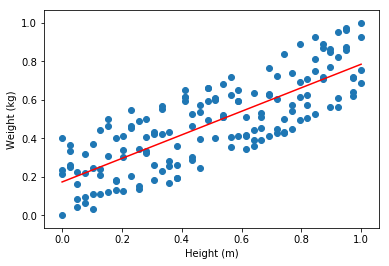

In [13]:
# Finding the extreme y coordinates for our line
y_min = beta_0 + (beta_1*np.min(x_norm))
y_max = beta_0 + (beta_1*np.max(x_norm))
# Plotting:
plt.scatter(x_norm, y_norm)
plt.xlabel('Height (m)')
plt.ylabel('Weight (kg)')
plt.plot([np.min(x_norm),np.max(x_norm)], [y_min,y_max],c='r')
plt.show()

Calculating **Least Squares Error** and **Mean Squared Error**:

In [14]:
lse = np.sum(np.square(y_norm - (beta_0 + np.multiply(beta_1,x_norm))))
mse = np.mean(np.square(y_norm - (beta_0 + np.multiply(beta_1,x_norm))))

print('Least Squares Error: %s' % lse)
print('Mean Squared Error: %s' % mse)

Least Squares Error: 2.99751657917
Mean Squared Error: 0.0187344786198


These are the least possible errors. There is no other line that can achieve lower errors.

<a id='comparing_solutions'></a>
### Comparing Solutions

The table below shows a comparisson among the 3 approaches used to solve this problem.

In [15]:
import pandas as pd
# The annotated results
analytic_solution = {'Mean Squared Error': 0.0187344786198, 'Least Squared Error': 2.99751657917, 'beta_0': 0.173145032501, 'beta_1': 0.6119508201 }
keras_1k = {'Mean Squared Error': 0.0187464144081, 'Least Squared Error': 2.99942620921, 'beta_0': 0.17115624, 'beta_1': 0.60921186 }
keras_10k = {'Mean Squared Error': 0.0187444284558, 'Least Squared Error': 2.99910858853, 'beta_0': 0.16777468, 'beta_1': 0.61720169 }
tensorflow_1k = {'Mean Squared Error': 0.170857409193, 'Least Squared Error': 27.3371854708, 'beta_0': 0.173145229628, 'beta_1': 0.611950453073 }
tensorflow_10k = {'Mean Squared Error': 0.0187344786198, 'Least Squared Error': 2.99751657917, 'beta_0': 0.173145032501, 'beta_1': 0.6119508201 }
# Columns
index=['Analytic Solution (reference)', 'Keras (1000 epochs)', 'Keras (10000 epochs)', 'Tensorflow (1000 epochs)', 'Tensorflow (10000 epochs)']
# Showing with panda
data = [analytic_solution, keras_1k, keras_10k, tensorflow_1k, tensorflow_10k]
df = pd.DataFrame(data, index)
df.style.set_properties(**{'text-align': 'center'})

,Least Squared Error,Mean Squared Error,beta_0,beta_1
Analytic Solution (reference),2.99752,0.0187345,0.173145,0.611951
Keras (1000 epochs),2.99943,0.0187464,0.171156,0.609212
Keras (10000 epochs),2.99911,0.0187444,0.167775,0.617202
Tensorflow (1000 epochs),27.3372,0.170857,0.173145,0.61195
Tensorflow (10000 epochs),2.99752,0.0187345,0.173145,0.611951


As we can see, the analytic solution is the one that has the least errors. And the more we train, the better our **Linear Regression** model gets.